In [1]:
!wget https://www.manythings.org/anki/rus-eng.zip
!unzip rus-eng.zip

--2021-04-02 15:56:24--  https://www.manythings.org/anki/rus-eng.zip
Resolving www.manythings.org (www.manythings.org)... 172.67.173.198, 104.21.55.222, 2606:4700:3036::ac43:adc6, ...
Connecting to www.manythings.org (www.manythings.org)|172.67.173.198|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14042100 (13M) [application/zip]
Saving to: ‘rus-eng.zip’

rus-eng.zip         100%[===================>]  13.39M  24.4MB/s    in 0.5s    

2021-04-02 15:56:24 (24.4 MB/s) - ‘rus-eng.zip’ saved [14042100/14042100]

Archive:  rus-eng.zip
  inflating: rus.txt                 
  inflating: _about.txt              


In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from keras.preprocessing.sequence import pad_sequences

if torch.cuda.is_available():
  dev = "cuda"
else:
  dev = 'cpu'

device = torch.device(dev)

In [4]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [5]:
def normalizeString(s):
    s = s.lower()
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Zа-яйёьъА-Яй]+", r" ", s)
    s = s.strip()
    return s

![2dword2vec](https://pytorch.org/tutorials/_images/word-encoding.png)

In [6]:
def readLangs(filename, lang1, lang2, reverse=False):
    pairs_array = []
    lines = open(filename, encoding='utf-8').read().strip().split('\n')

    for line in lines:
      pair = list(map(normalizeString, line.split('\t')[:2]))
      pairs_array.append(pair)

    if reverse:
        pairs_array = [list(reversed(p)) for p in pairs_array]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs_array

input_lang, output_lang, pairs = readLangs('rus.txt', 'en', 'ru', True)
input_lang.name, output_lang.name, pairs[:5]

('ru',
 'en',
 [['марш', 'go'],
  ['иди', 'go'],
  ['идите', 'go'],
  ['здравствуйте', 'hi'],
  ['привет', 'hi']])

In [7]:
len(pairs)

421765

In [8]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filter_pairs(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH and p[1].startswith(eng_prefixes)

def prepareData(input_lang, output_lang, pairs):
    print("Read %s sentence pairs" % len(pairs))
    reduced_pairs = list(filter(filter_pairs, pairs))
    print("Trimmed to %s sentence pairs" % len(reduced_pairs))
    print("Counting words...")
    for pair in reduced_pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    random.shuffle(reduced_pairs)
    return input_lang, output_lang, reduced_pairs

input_lang, output_lang, reduced_pairs = prepareData(input_lang, output_lang, pairs)
print(random.choice(reduced_pairs))

Read 421765 sentence pairs
Trimmed to 26603 sentence pairs
Counting words...
Counted words:
ru 9835
en 4098
['я тощий', 'i m skinny']


In [10]:
!nvidia-smi

Fri Apr  2 16:00:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    27W /  70W |   1054MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
def pad(x, length=None):
    if length is None:
        length = max([len(sentence) for sentence in x])
    return pad_sequences(x, maxlen = length, padding = 'EOS')

def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence, max_len):
    indexes = pad(indexesFromSentence(lang, sentence), max_len)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def pad(x, length):
    if len(x) < length:
      x += [EOS_token] * (length - len(x))
    return x

def tensorsFromPair(pair, max_len):
    input_tensor = tensorFromSentence(input_lang, pair[0], max_len)
    target_tensor = tensorFromSentence(output_lang, pair[1], max_len)
    return (input_tensor, target_tensor)

def test():
  random_pair = random.choice(reduced_pairs)
  print(random_pair)
  print(tensorsFromPair(random_pair, MAX_LENGTH))

test()

['я рад что люди его видели', 'i m glad people saw it']
(tensor([[  10],
        [  76],
        [1236],
        [ 435],
        [ 493],
        [4881],
        [   1],
        [   1],
        [   1],
        [   1]], device='cuda:0'), tensor([[   2],
        [   3],
        [  38],
        [ 522],
        [1725],
        [ 167],
        [   1],
        [   1],
        [   1],
        [   1]], device='cuda:0'))


In [11]:
class MTDataset(Dataset):
  def __init__(self, training_pairs, max_sent_len = 10):
    self.training_pairs = training_pairs
    self.max_sent_len = max_sent_len

  def __len__(self):
    return len(self.training_pairs)

  def __getitem__(self, idx):
    pair = self.training_pairs[idx]
    tensor_pair = tensorsFromPair(pair, MAX_LENGTH)
    return tensor_pair


def test__MTDataset():
  BATCH_SIZE = 128
  mt_dataset = MTDataset(reduced_pairs)
  mt_dataloder = DataLoader(mt_dataset, batch_size=BATCH_SIZE, drop_last=True)

  for batch in mt_dataloder:
    x = batch
  return x[0].shape, x[1].shape

test__MTDataset()

(torch.Size([128, 10, 1]), torch.Size([128, 10, 1]))

![encoder_rnn](https://pytorch.org/tutorials/_images/encoder-network.png)

In [12]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden, batch_size):
        embedded = self.embedding(input).view(1, batch_size, self.hidden_size)
        output = embedded
        # print(output.shape, hidden.shape)
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)

![decoder_rnn](https://pytorch.org/tutorials/_images/decoder-network.png)

In [14]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, batch_size):
        output = self.embedding(input).view(1, batch_size, self.hidden_size)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)

![seq2seq_pipleine](https://camo.githubusercontent.com/fe3df3ef6c0fb05767a373ef8e547120a0a667c423a5c52f3f202156b8aba1e5/68747470733a2f2f696e6372656469626c652e61692f6173736574732f696d616765732f736571327365712d736571327365715f74732e706e67)

In [15]:
def train_on_batch(input_tensor, target_tensor, encoder, decoder, 
                    encoder_optimizer, decoder_optimizer, criterion, 
                    use_attention, batch_size, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden(batch_size)

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(1)
    target_length = target_tensor.size(1)

    encoder_outputs = torch.zeros((batch_size, max_length, encoder.hidden_size),dtype=torch.float, device=device)

    loss = 0
    for ei in range(input_length):
      encoder_output, encoder_hidden = encoder(input_tensor[:, ei], encoder_hidden, batch_size)
      encoder_outputs[:, ei] = encoder_output[:, 0]

    decoder_input = torch.tensor([[SOS_token] * batch_size],dtype=torch.long, device=device).view(batch_size)
    decoder_hidden = encoder_hidden
    
    if use_attention:
      decoder_attentions = torch.zeros((batch_size, max_length, max_length))

    for di in range(target_length):
        if use_attention:
          decoder_output, decoder_hidden, decoder_attention = decoder.forward(decoder_input, decoder_hidden, encoder_outputs, batch_size)
          decoder_attentions[:, di] = decoder_attention.data
        else:
          decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, batch_size)

        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()

        loss += criterion(decoder_output, target_tensor[:, di])

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

## Attention Decoder

![attention_rnn](https://pytorch.org/tutorials/_images/attention-decoder-network.png)

In [17]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs, batch_size):
        output = self.embedding(input).view(1, batch_size, self.hidden_size)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        # print(output.shape, hidden.shape)
        attn_weights = F.softmax(self.attn(torch.cat((output[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.view(batch_size, 1, -1), encoder_outputs)
        # print(attn_applied.shape)
        output = torch.cat((output.squeeze(0), attn_applied.squeeze(1)), 1)
        output = self.attn_combine(output).unsqueeze(0)
        output = F.log_softmax(self.out(output[0]), dim=1)
        # print(output.shape, hidden.shape, attn_weights.shape)
        return output, hidden, attn_weights


    def forward(self, input, hidden, encoder_outputs, batch_size):
        embedded = self.embedding(input).view(batch_size, self.hidden_size)
        # print('embedded: ', embedded.shape)
        embedded = self.dropout(embedded)
        # print('embeded dropout: ', embedded.shape)
        # print('embedded: ', embedded.shape)
        # print('hidden: ', hidden.shape)
        # print('self.attn(torch.cat((embedded, hidden[0]), 1)): ', torch.cat((embedded, hidden[0]), 1).shape)
        attn_weights = F.softmax(self.attn(torch.cat((embedded, hidden[0]), 1)), dim=1)
        # print('attn_weights: ', attn_weights.shape)
        # print('encoder_outputs:', encoder_outputs.shape)
        # print('attn_weights: ', attn_weights.view(batch_size, 1, -1).shape)
        # print('encoder_outputs: ', encoder_outputs.shape)
        #Batch Matrix Multiplication: b*n*m @ b*m*p = b*n*p
        attn_applied = torch.bmm(attn_weights.view(batch_size, 1, -1), encoder_outputs)
        # print('embeded: ', embedded.shape)
        # print('attn_applied: ', attn_applied.squeeze(1).shape)
        output = torch.cat((embedded, attn_applied.squeeze(1)), 1)
        # print('output: ', output.shape)
        output = self.attn_combine(output).unsqueeze(0)
        # print('attn_combine result', output.shape)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        # print('output: ', output.shape)
        # print('attn_weights: ', attn_weights.shape)

        # print("Attention logic:")
        # print(f"1) Calculate Attention scores")
        # print(f"attn_weights = concat(input_embedding {embedded.shape}, decoder_hidden {hidden[0].shape} @ W {self.hidden_size * 2, self.max_length}")
        # print()
        # print(f"2) Softmax attention scores - attn_weights = softmax(attn_weights)")
        # print()
        # print(f"3) For every element in encoder_outputs apply corresponding attention score")
        # print(f"attn_applied = attn_weights {attn_weights.shape} @ encoder_outputs {encoder_outputs[0].shape}")
        # print()
        # print(f"4) Concat again input embeddings and calculated attention scores")
        # print(f"attention output = concat(embedded {embedded.shape}, attn_applied {attn_applied.squeeze(1).shape}) @ W({self.hidden_size * 2, self.hidden_size})")
        # print()
        # print(f'5) Run decoder pipeline\n')

        return output, hidden, attn_weights


    def initHidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)

In [18]:
def test__train_on_batch(use_attention=False):
  BATCH_SIZE = 2
  hidden_size = 256
  LEARNING_RATE = 1e-5
  encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
  decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)
  if use_attention:
    decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

  mt_dataset = MTDataset(reduced_pairs)
  mt_dataloder = DataLoader(mt_dataset, batch_size=BATCH_SIZE, drop_last=True)

  for batch in mt_dataloder:
    input_tensor, target_tensor = batch[0].view(BATCH_SIZE, MAX_LENGTH), batch[1].view(BATCH_SIZE, MAX_LENGTH)

  encoder_optimizer = optim.Adam(encoder.parameters(), lr=LEARNING_RATE)
  decoder_optimizer = optim.Adam(decoder.parameters(), lr=LEARNING_RATE)

  criterion = nn.NLLLoss()

  loss = train_on_batch(input_tensor, target_tensor, encoder, decoder, 
                        encoder_optimizer, decoder_optimizer, criterion, 
                        use_attention, BATCH_SIZE)
  return loss

test__train_on_batch(False)

8.311598968505859

In [19]:
def evaluate_sample(encoder, decoder, sentence, use_attention, batch_size, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence, max_length).view(batch_size, max_length)
        input_length = input_tensor.size()[1]
        encoder_hidden = encoder.initHidden(batch_size)

        encoder_outputs = torch.zeros((batch_size, max_length, encoder.hidden_size),dtype=torch.float, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[:, ei],
                                                     encoder_hidden, batch_size)
            encoder_outputs[:, ei] += encoder_output[:, 0]

        decoder_input = torch.tensor([[SOS_token] * batch_size],dtype=torch.long, device=device).view(batch_size)
        decoder_hidden = encoder_hidden

        decoded_words = []
        if use_attention:
          decoder_attentions = torch.zeros((batch_size, max_length, max_length))

        for di in range(max_length):
            if use_attention:
              decoder_output, decoder_hidden, decoder_attention = decoder.forward(decoder_input, decoder_hidden, encoder_outputs, batch_size)
              decoder_attentions[:, di] = decoder_attention.data
            else:
              decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, batch_size)

            topv, topi = decoder_output.data.topk(1)
            decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()
        if use_attention:
          return decoded_words, decoder_attentions[:, :di + 1]
        else:
          return decoded_words


def test__evaluate_sample(use_attention):
  hidden_size = 256
  BATCH_SIZE = 1
  print(input_lang.name, input_lang.n_words)
  print(output_lang.name, output_lang.n_words)
  encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
  decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)
  if use_attention:
    decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)
  random_sentence = random.choice(reduced_pairs)[0]
  print(random_sentence)
  if use_attention:
    result, attention_scores = evaluate_sample(encoder, decoder, random_sentence, use_attention, BATCH_SIZE, MAX_LENGTH)
    result = " ".join(result)
  else:
    result = " ".join(evaluate_sample(encoder, decoder, random_sentence, use_attention, BATCH_SIZE, MAX_LENGTH))
  return result

test__evaluate_sample(True)

ru 9835
en 4098
ему нравятся его новые ботинки


'reader rush harm bitter hottie hottie practice practice hottie practice'

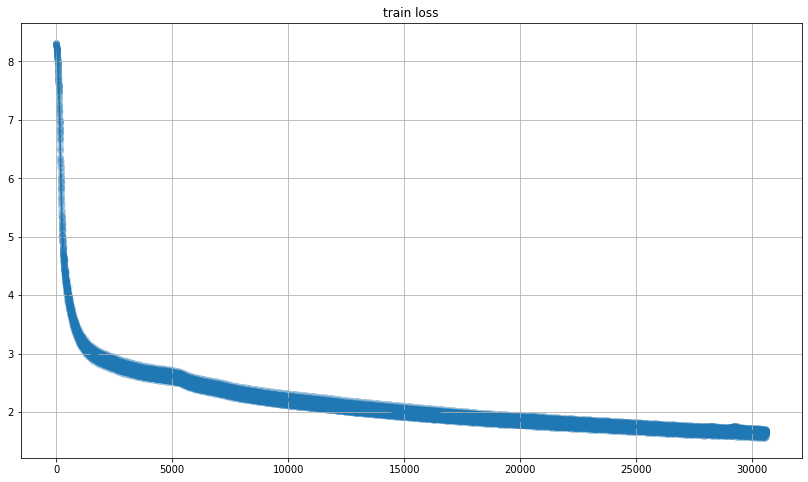

In [ ]:
EPOCH_NUM = 600
PRINT_EVERY = 50
PLOT_EVERY = 50
LEARNING_RATE = 1e-5
BATCH_SIZE= 512

f = open('progress_log.txt', 'w')

mt_dataset = MTDataset(reduced_pairs)
mt_dataloder = DataLoader(mt_dataset, batch_size=BATCH_SIZE, drop_last=True)

ewma = lambda x, span: pd.DataFrame({'x': x})['x'].ewm(span=span).mean().values

hidden_size = 256
use_attention=True
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
if use_attention:
  decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)
else:
  decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)


encoder_optimizer = optim.Adam(encoder.parameters(), lr=LEARNING_RATE)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=LEARNING_RATE)

criterion = nn.NLLLoss()
loss_array = []

for epoch in range(EPOCH_NUM):
  for batch_id, batch in enumerate(mt_dataloder):
    input_tensor = batch[0].view(BATCH_SIZE, MAX_LENGTH)
    target_tensor = batch[1].view(BATCH_SIZE, MAX_LENGTH)

    loss = train_on_batch(input_tensor, target_tensor, encoder, decoder, 
                          encoder_optimizer, decoder_optimizer, criterion, 
                          use_attention=use_attention, batch_size=BATCH_SIZE)
    
    loss_array.append(loss)

    if batch_id % PRINT_EVERY == 0:
        print(f'Epoch = {epoch}, current progress = {(batch_id * BATCH_SIZE)/len(reduced_pairs)} %, current loss = {loss_array[-1]}')
        with open('progress_log.txt', 'a') as f:
            pair = random.choice(reduced_pairs)
            if use_attention:
              result, _ = evaluate_sample(encoder, decoder, pair[0], use_attention, 1, MAX_LENGTH)
              output_sentence = " ".join(result)
            else:
              output_sentence = " ".join(evaluate_sample(encoder, decoder, pair[0], use_attention, 1, MAX_LENGTH))

            f.write(f'Epoch = {epoch}, current progress = {(batch_id * BATCH_SIZE)/len(reduced_pairs)} %, current loss = {loss_array[-1]}\n')
            f.write(f'>{pair[0]}\n')
            f.write(f'={pair[1]}\n')
            f.write(f'<{output_sentence}\n')
            f.write('####################\n')


    if batch_id % PLOT_EVERY == 0:
        clear_output(True)
        plt.figure(figsize=[14, 8])
        plt.subplot(1, 1, 1), plt.title('train loss'), plt.grid()
        plt.scatter(np.arange(len(loss_array)), loss_array, alpha=0.12)
        plt.plot(ewma(loss_array, span=10))
        plt.show()

In [ ]:
def evaluateRandomly(pairs, encoder, decoder, use_attention, batch_size, n = 10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        if use_attention:
          result, _ = evaluate_sample(encoder, decoder, pair[0], use_attention, 1, MAX_LENGTH)
          output_sentence = " ".join(result)
        else:
          output_sentence = " ".join(evaluate_sample(encoder, decoder, pair[0], use_attention, 1, MAX_LENGTH))
        print('<', output_sentence)
        print('')

evaluateRandomly(reduced_pairs, encoder, decoder, True, 1)

> я просто не уверена
= i m just not sure
< i m not going of EOS EOS EOS EOS EOS

> ты поправишься
= you re going to get better
< you re so good EOS EOS EOS EOS EOS EOS

> я старый друг
= i m an old friend
< i m a a my EOS EOS EOS EOS EOS

> я поливаю цветы
= i am watering the flowers
< i m a a EOS EOS EOS EOS EOS EOS

> вы очень больны
= you re very sick
< you re very very EOS EOS EOS EOS EOS EOS

> я всегда прихожу первой
= i m always the first to arrive
< i m going to to to a EOS EOS EOS

> я худею
= i m losing weight
< i m a EOS EOS EOS EOS EOS EOS EOS

> я хороший мальчик
= i am a good boy
< i m a a EOS EOS EOS EOS EOS EOS

> мы тут обедаем
= we re having lunch here
< we re going to EOS EOS EOS EOS EOS EOS

> я рада что вы знаете правду
= i m glad you know the truth
< i m glad you re you EOS EOS EOS EOS



In [20]:
from torchtext.data.metrics import bleu_score
# from tqdm import tqdm_notebook

i m a EOS EOS EOS EOS EOS EOS EOS - [a]

i m losing weight = [b_1], i am getting thinner = [b_2] - > a * (b_1 + b_2)

BLEU(переведенный текст, варианты перевода проверенные ассесорами)

candidate_corpus = [['My', 'full', 'pytorch', 'test'], ['Another', 'Sentence']]
references_corpus = [[['My', 'full', 'pytorch', 'test'], ['test','text']], [['No', 'Match']]]
print('Example BLEU score: ', bleu_score(candidate_corpus, references_corpus))

Example BLEU score:  0.8408964276313782


In [ ]:
#bleu score
from torchtext.data.metrics import bleu_score
from tqdm import tqdm_notebook

candidate_corpus = [['My', 'full', 'pytorch', 'test'], ['Another', 'Sentence']]
references_corpus = [[['My', 'full', 'pytorch', 'test']], [['No', 'Match']]]
print('Example BLEU score: ', bleu_score(candidate_corpus, references_corpus))

#evaluate on train
predicated_array = []
true_array = []
use_attention = True
for i in tqdm_notebook(range(len(reduced_pairs[:]))):
  input_sent = reduced_pairs[i][0]
  true_sent = reduced_pairs[i][1]

  if use_attention:
    pred_sent,_  = evaluate_sample(encoder, decoder, input_sent, use_attention, 1, MAX_LENGTH)
  else:
    pred_sent  = evaluate_sample(encoder, decoder, input_sent, use_attention, 1, MAX_LENGTH)

  pred_sent = list(filter(lambda x: x!= 'EOS', pred_sent))

  true_array.append([true_sent.split()])
  predicated_array.append(pred_sent)

print('BLEU score: ', bleu_score(predicated_array, true_array))

Example BLEU score:  0.8408964276313782


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]



BLEU score:  0.19361915088476583


input = я рада что вы знаете правду
output = i m glad you re you EOS EOS EOS EOS


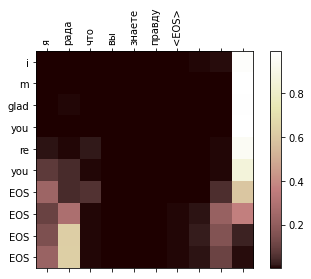

In [ ]:
import matplotlib.ticker as ticker


def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='pink')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence, encoder, attn_decoder):
    output_words, attentions = evaluate_sample(encoder, decoder, input_sentence, use_attention, 1, MAX_LENGTH)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions.squeeze(0))


evaluateAndShowAttention('я рада что вы знаете правду', encoder, decoder)

![beam_search](https://programmersought.com/images/390/e3a3ee5a2b55978cef16564232dda266.JPEG)